CMPSC497 Introduction to Data Mining - Programming Assignment 3

Bert Yan

Original work done by me.

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.feature_selection as fs
import sklearn.preprocessing as pp
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score, fowlkes_mallows_score, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score, calinski_harabasz_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn import datasets

from sklearn.cluster import AgglomerativeClustering

from sklearn.neighbors import NearestCentroid

data = pd.read_csv('credit cards-2022-post.csv')

In [2]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,5771,180000,1,2,1,38,1,2,2,0,...,5071,5195,0,2000,200,500,124,0,0,1
1,3999,20000,2,1,2,23,2,2,2,2,...,12957,13104,12744,3500,200,1000,500,0,1000,1
2,397,100000,1,1,2,38,0,0,0,0,...,43011,43011,28947,2502,1200,860,0,579,0,0
3,15467,220000,1,1,2,30,2,0,0,0,...,90889,91892,93815,5000,5000,4200,4000,4000,5000,0
4,16482,240000,2,4,1,59,0,0,0,0,...,241075,146440,132290,8357,10001,10000,10000,5000,20000,0


# Dataset and new features
Remaining Balance, and add them (6 features/columns in total) to the dataset.
Experimentally, you will use Remaining Balance, Bill Amount, and Pay Amount
(18 features in total)

# Implementation and Experiments

## Task 1 Data Preprocessing

a) calculate new features Remaining Balance = Bill Amount – Pay Amount and add them

In [3]:
# First we Create and add Remaining balance (REM_AMT) = Bill Amt - Pay Amt
for i in range(1, 7):
    data['REM_AMT'+str(i)] = data['BILL_AMT'+str(i)] - data['PAY_AMT'+str(i)]

In [4]:
# Now, check out new features
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,REM_AMT1,REM_AMT2,REM_AMT3,REM_AMT4,REM_AMT5,REM_AMT6
0,5771,180000,1,2,1,38,1,2,2,0,...,124,0,0,1,826,4412,4071,4947,5195,0
1,3999,20000,2,1,2,23,2,2,2,2,...,500,0,1000,1,6236,12559,11459,12457,13104,11744
2,397,100000,1,1,2,38,0,0,0,0,...,0,579,0,0,38308,41453,41491,43011,42432,28947
3,15467,220000,1,1,2,30,2,0,0,0,...,4000,4000,5000,0,79630,82604,85487,86889,87892,88815
4,16482,240000,2,4,1,59,0,0,0,0,...,10000,5000,20000,0,225561,225403,226564,231075,141440,112290


In [5]:
#Next, we modify our dataset to only contain 18 categories: BILL_AMT, PAY_AMT, and REM_AMT
categories = []

for i in range(1, 7):
    categories.append('BILL_AMT'+str(i))
    categories.append('PAY_AMT'+str(i))
    categories.append('REM_AMT'+str(i))
    
dataset = pd.DataFrame(data, columns=categories)

b) apply Principal Component Analysis (PCA) from sklearn to reduce the dimensionality of attributes to 3 (i.e., n_components=3). Note that normalizing the attributes by standardization before PCA is a common practice.

In [6]:
# Standarization for part b)
standardScaler = pp.StandardScaler()
dataset = pd.DataFrame(standardScaler.fit_transform(dataset), columns=categories)
dataset.head()

,BILL_AMT1,PAY_AMT1,REM_AMT1,BILL_AMT2,PAY_AMT2,REM_AMT2,BILL_AMT3,PAY_AMT3,REM_AMT3,BILL_AMT4,PAY_AMT4,REM_AMT4,BILL_AMT5,PAY_AMT5,REM_AMT5,BILL_AMT6,PAY_AMT6,REM_AMT6
0,-0.661096,-0.216712,-0.614507,-0.627844,-0.237323,-0.532575,-0.612107,-0.274410,-0.544000,-0.596510,-0.294516,-0.523682,-0.580101,-0.310517,-0.500643,-0.656632,-0.291441,-0.563376
1,-0.566391,-0.127640,-0.539944,-0.512951,-0.237323,-0.420515,-0.498639,-0.245236,-0.437813,-0.473376,-0.270893,-0.406337,-0.449185,-0.310517,-0.369521,-0.441494,-0.235534,-0.366951
2,-0.140504,-0.186903,-0.097912,-0.091372,-0.196410,-0.023087,-0.068645,-0.253405,-0.006167,-0.004104,-0.302306,0.071076,0.045858,-0.273432,0.116706,-0.167963,-0.291441,-0.079222
3,0.460074,-0.038568,0.471607,0.542549,-0.040939,0.542932,0.612279,-0.058520,0.626181,0.743475,-0.050996,0.756679,0.854974,-0.054315,0.870385,0.927107,-0.011905,0.922103
4,2.506150,0.160776,2.482897,2.626895,0.163668,2.507089,2.725092,0.279902,2.653862,3.088519,0.325970,3.009616,1.757894,0.009736,1.758154,1.576624,0.826702,1.314735


In [7]:
# After Standarization, we peform PCA to reduce dimensionality to 3
pca = PCA(n_components=3)
standardData = pd.DataFrame(pca.fit_transform(dataset))
standardData.head()

,0,1,2
0,-2.098892,-0.332516,-0.076863
1,-1.650147,-0.298458,-0.108874
2,-0.213882,-0.537101,-0.109666
3,2.363767,-0.331052,-0.296935
4,8.117194,-0.681423,1.196390


c)  perform normalization (into [0,1]) on the three attributes used for clustering.

In [8]:
# Normalization to modify values to range [0,1]
normScaler = pp.MinMaxScaler()
normalData = pd.DataFrame(normScaler.fit_transform(standardData))
normalData.head()

,0,1,2
0,0.076566,0.035675,0.371407
1,0.090043,0.036034,0.370660
2,0.133176,0.033519,0.370642
3,0.210587,0.035690,0.366272
4,0.383373,0.031999,0.401118


## Task 2. Implementation of the Agglomerative Hierarchical Clustering (MIN) algorithm

a) to d) are given in report pdf based on codes, please refer to the implementation below for details.

e) Given a dataset and a
parameter n_clusters, your code should return the specified number of clusters,
each of which represented in the data structure of your design. Additionally, a
label (i.e., 1, 2, ..., n_clusters) should be assigned to every data point in the
dataset. In this task, please use the first 100 data points from Task 1 and
n_clusters = 5 to generate your clustering result

In [9]:
# We need to use the values from the pandas dataframe
# Pandas.dataframe -> sklearn.dataset, this can be achieved using .values for our dataframe to get the arrays
# Alternatively, normalData.to_numpy()

print(normalData.values)

[[0.07656593 0.03567504 0.37140713]
 [0.09004252 0.03603389 0.37066017]
 [0.13317612 0.03351942 0.37064169]
 ...
 [0.1942888  0.03697921 0.36830669]
 [0.07744148 0.0422891  0.37588903]
 [0.30097797 0.03425128 0.38146709]]


In [10]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
import numpy as np

class agglomerative:
    # initialize variables in class
    def __init__(self, **kwargs):
        self.__pointer_data = []
        self.__clusters = []
        self.__memory = [] 
        self.__distance_matrix = []
        self.__n_clusters = kwargs.get('n_clusters', 2)
        self.__linkage = kwargs.get('linkage', 'single')
        self.__metric = kwargs.get('metric', 'euclidean')
    
    def preparation(self):
        # create distance matrix for each data
        if self.__metric == 'euclidean':
            self.__distance_matrix = euclidean_distances(self.__pointer_data)
        elif self.__metric == 'manhattan':
            self.__distance_matrix = manhattan_distances(self.__pointer_data)
        elif self.__metric == 'cosine':
            self.__distance_matrix = cosine_distances(self.__pointer_data)
            
        n_data = len(self.__pointer_data)
        self.__clusters = [0] * len(self.__pointer_data)
        # create singleton cluster
        for i in range(0, n_data):
            self.__memory.append([i])
        
    def clustering(self):
        # iteration to produce n_clusters
        for iteration in range(len(self.__pointer_data) - self.__n_clusters):
            cluster_a = 0
            cluster_b = 1
            if (len(self.__memory[0])==1) and (len(self.__memory[1])==1): 
                # distance between singleton cluster
                min_distance = self.__distance_matrix[0][1]
            else: 
                # distance between multi-elements cluster
                min_distance = self.cluster_distance(self.__memory[0], self.__memory[1])
            
            # find two nearest data or clusters to be combined into one cluster
            for i in range(len(self.__memory)):
                for j in range(len(self.__memory)):
                    if (i != j) and (i < j):
                        if (len(self.__memory[i])==1) and (len(self.__memory[j])==1):
                            # distance between singleton cluster
                            dist = self.__distance_matrix[i][j] 
                        else:
                            # distance between multi-elements cluster
                            dist = self.cluster_distance(self.__memory[i], self.__memory[j])
                        if dist < min_distance:
                            cluster_a = i
                            cluster_b = j
                            min_distance = dist
            temp = self.__memory.pop(cluster_b)
            for i in range(len(temp)):
                self.__memory[cluster_a].append(temp[i])
    
    # calculate distance between clusters or data and cluster
    def cluster_distance(self, a, b):
        distance = 0
        if self.__linkage == 'single': # distance between two nearest data in cluster
            distance = self.__distance_matrix[a[0]][b[0]]
            for i in a:
                for j in b:
                    if distance > self.__distance_matrix[i][j]:
                        distance = self.__distance_matrix[i][j]
        elif self.__linkage == 'complete': # distance between two furthest data in cluster
            for i in a:
                for j in b:
                    if distance < self.__distance_matrix[i][j]:
                        distance = self.__distance_matrix[i][j]
        elif self.__linkage == 'average': # average distance between data in clusters
            for i in a:
                for j in b:
                    distance += self.__distance_matrix[i][j]
            distance = distance/(len(a) * len(b))
        elif self.__linkage == 'average_group': # distance between two clusters mean
            member_a = []
            member_b = []
            for i in a:
                member_a.append(self.__pointer_data[i])
            for i in b:
                member_b.append(self.__pointer_data[i])
            mean_a = np.array(member_a).mean(axis=0)
            mean_b = np.array(member_b).mean(axis=0)
            mean_clusters = []
            mean_clusters.append(mean_a)
            mean_clusters.append(mean_b)
            if self.__metric == 'euclidean':
                distance = euclidean_distances(mean_clusters)[0][1]
            elif self.__metric == 'manhattan':
                distance = manhattan_distances(mean_clusters)[0][1]
            elif self.__metric == 'cosine':
                distance = cosine_distances(mean_clusters)[0][1]
        return distance
    
    # return predicted cluster
    def get_clusters(self):
        return self.__memory
    
    # fit and predict data with the agglomerative model
    def fit_predict(self, data):
        self.__pointer_data = []
        self.__clusters = []
        self.__memory = []
        self.__distance_matrix = []
        self.__pointer_data = data
        self.preparation()
        self.clustering()
        for i in range(len(self.__memory)):
            for j in self.__memory[i]:
                self.__clusters[j] = i
        return self.__clusters

In [11]:
# Results: running custom method on first 100 data points

model = agglomerative(metric='euclidean', linkage='single', n_clusters=5)
predict = model.fit_predict(normalData.values[:100])
print("Labels prediction: \n", predict)

clusters = model.get_clusters()
print("\nWe have the following clusters: \n", clusters)

Labels prediction: 
 [0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We have the following clusters: 
 [[0, 45, 30, 74, 82, 10, 15, 53, 81, 52, 16, 55, 32, 37, 59, 90, 18, 71, 33, 19, 76, 40, 47, 17, 58, 20, 64, 98, 6, 25, 65, 67, 69, 75, 77, 43, 51, 31, 41, 49, 57, 87, 84, 88, 1, 13, 62, 94, 60, 93, 61, 91, 66, 70, 36, 44, 68, 72, 21, 24, 26, 34, 39, 2, 11, 28, 14, 54, 73, 78, 12, 50, 8, 48, 92, 83, 97, 95, 99, 56, 85, 38, 46, 35, 42, 22, 27, 9, 63, 96, 3, 23, 29, 5], [4], [7], [79, 86], [80, 89]]


## Task 3. Hierarchical Clustering

a) Perform the agglomerative hierarchical clustering (MIN) to cluster the data
obtained from Task 1. 

* Note: Using My own implementation for agglomerative hierarchical clustering

In [12]:
# Hierarchical clustering using average linkage
min = AgglomerativeClustering(n_clusters=5, linkage='single')
# Fit & predict
min_pred = min.fit_predict(normalData.values)

In [13]:
print("Cluster 1: \n", np.where(min_pred == 0))
print("\nCluster 2: \n", np.where(min_pred == 1))
print("\nCluster 3: \n", np.where(min_pred == 2))
print("\nCluster 4: \n", np.where(min_pred == 3))
print("\nCluster 5: \n", np.where(min_pred == 4))

Cluster 1: 
 (array([ 2561, 16914], dtype=int64),)

Cluster 2: 
 (array([    0,     1,     2, ..., 23997, 23998, 23999], dtype=int64),)

Cluster 3: 
 (array([865], dtype=int64),)

Cluster 4: 
 (array([9814], dtype=int64),)

Cluster 5: 
 (array([ 1780, 21829], dtype=int64),)


In [14]:
# Import scipy's linkage function to conduct the clustering
from scipy.cluster.hierarchy import linkage
linkage_type = 'average'
linkage_matrix = linkage(normalData, linkage_type)

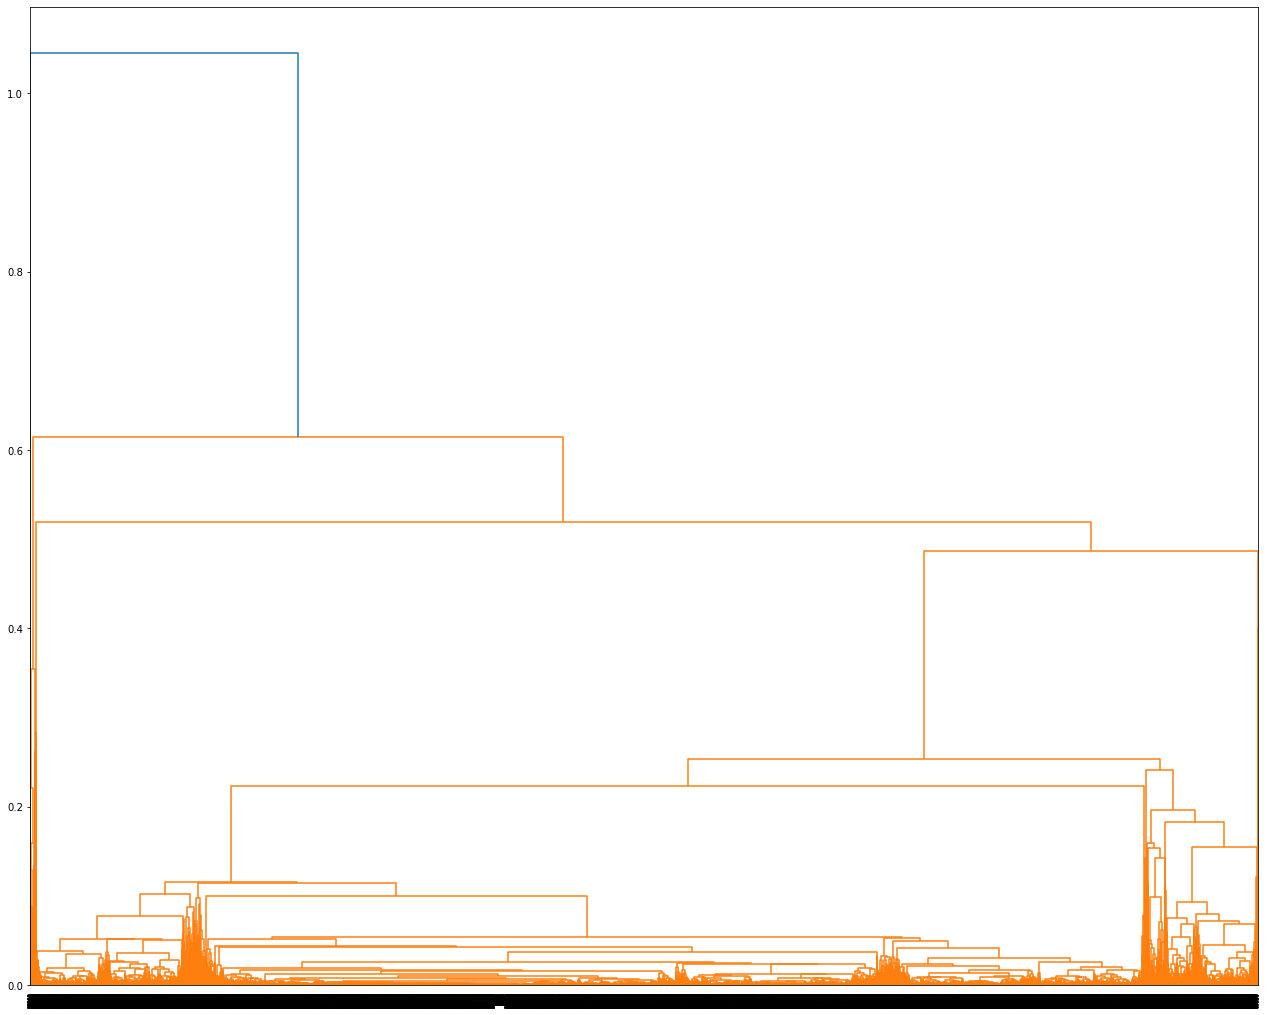

In [15]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(22,18))

# plot using 'dendrogram()'
dendrogram(linkage_matrix)

plt.show()

In [16]:
# Hierarchical clustering using complete linkage
max = AgglomerativeClustering(n_clusters=5, linkage='complete')
# Fit & predict
max_pred = max.fit_predict(normalData.values)

In [17]:
print("Cluster 1: \n", np.where(max_pred == 0))
print("\nCluster 2: \n", np.where(max_pred == 1))
print("\nCluster 3: \n", np.where(max_pred == 2))
print("\nCluster 4: \n", np.where(max_pred == 3))
print("\nCluster 5: \n", np.where(max_pred == 4))

Cluster 1: 
 (array([    0,     1,     2, ..., 23997, 23998, 23999], dtype=int64),)

Cluster 2: 
 (array([ 2561,  9814, 16914], dtype=int64),)

Cluster 3: 
 (array([  959,  5070,  8869, 11082, 15532, 17727, 17729, 19622, 21171,
       21712, 21852], dtype=int64),)

Cluster 4: 
 (array([   62,  1409,  1780,  2515,  2620,  3303,  5509,  6664,  7361,
        7453,  8527,  8775,  9157, 10972, 11131, 11875, 12987, 13291,
       13338, 13872, 14670, 16244, 16372, 16982, 17509, 18245, 18620,
       20032, 21079, 21312, 21829, 22725, 23917], dtype=int64),)

Cluster 5: 
 (array([   98,  1002,  1087,  1165,  1801,  1805,  2004,  2115,  2793,
        2832,  2875,  3504,  3816,  4678,  5311,  5767,  5844,  5941,
        6307,  6409,  6920,  7054,  8409,  8602,  8994,  9192,  9407,
        9498,  9558,  9701, 10109, 10300, 10512, 10826, 10991, 11352,
       11739, 12206, 13438, 13572, 13590, 14015, 14369, 14698, 14783,
       14986, 15822, 15968, 16059, 16824, 16939, 17337, 17432, 17543,
       175

In [18]:
# Import scipy's linkage function to conduct the clustering
from scipy.cluster.hierarchy import linkage
linkage_type = 'complete'
linkage_matrix = linkage(normalData, linkage_type)

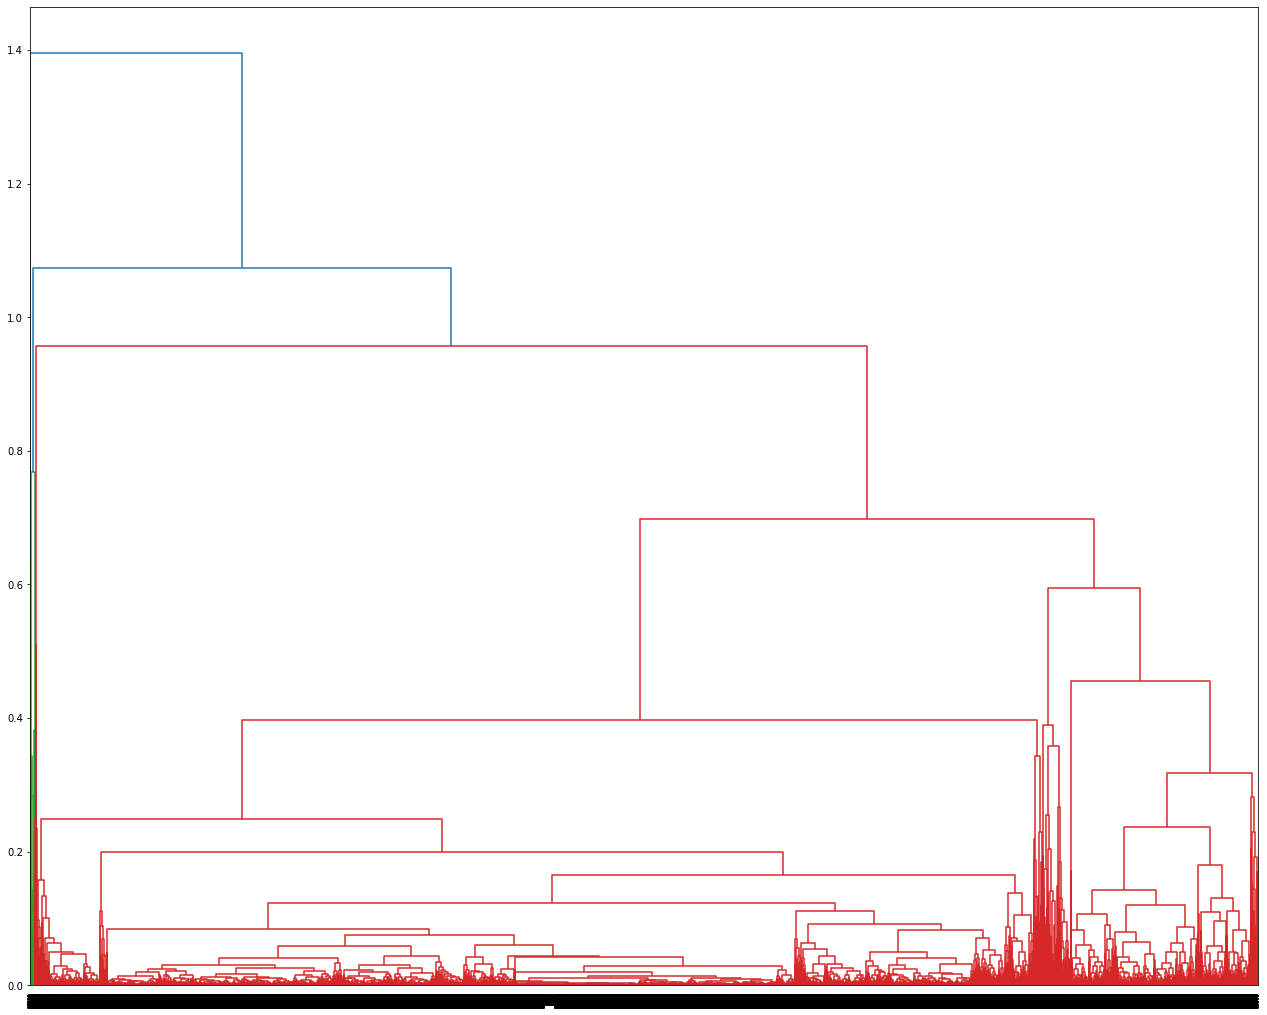

In [19]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(22,18))

# plot using 'dendrogram()'
dendrogram(linkage_matrix)

plt.show()

In [20]:
# Hierarchical clustering using Ward linkage
ward = AgglomerativeClustering(n_clusters=5, linkage='ward')
# Fit & predict
ward_pred = ward.fit_predict(normalData.values)

In [21]:
print("Cluster 1: \n", np.where(ward_pred == 0))
print("\nCluster 2: \n", np.where(ward_pred == 1))
print("\nCluster 3: \n", np.where(ward_pred == 2))
print("\nCluster 4: \n", np.where(ward_pred == 3))
print("\nCluster 5: \n", np.where(ward_pred == 4))

Cluster 1: 
 (array([    2,     5,     7, ..., 23978, 23991, 23992], dtype=int64),)

Cluster 2: 
 (array([    4,    62,    83, ..., 23925, 23956, 23979], dtype=int64),)

Cluster 3: 
 (array([    3,    35,    39, ..., 23996, 23997, 23999], dtype=int64),)

Cluster 4: 
 (array([   86,    98,   202,   410,   466,   523,   553,   576,   609,
         649,   661,   853,   913,   957,   983,  1002,  1087,  1111,
        1150,  1165,  1171,  1175,  1177,  1337,  1338,  1449,  1466,
        1482,  1625,  1720,  1723,  1801,  1805,  2004,  2014,  2030,
        2115,  2133,  2169,  2196,  2261,  2396,  2499,  2604,  2750,
        2761,  2793,  2798,  2799,  2808,  2816,  2832,  2842,  2875,
        2994,  3103,  3119,  3125,  3482,  3504,  3537,  3620,  3715,
        3749,  3816,  3866,  3974,  3994,  4041,  4167,  4174,  4481,
        4494,  4524,  4564,  4668,  4678,  4688,  4757,  4781,  5145,
        5311,  5467,  5495,  5513,  5610,  5681,  5753,  5754,  5767,
        5844,  5941,  6008,  60

In [22]:
# Import scipy's linkage function to conduct the clustering
from scipy.cluster.hierarchy import linkage
linkage_type = 'ward' # Ward has the highest adjusted_rand_score
linkage_matrix = linkage(normalData, linkage_type)

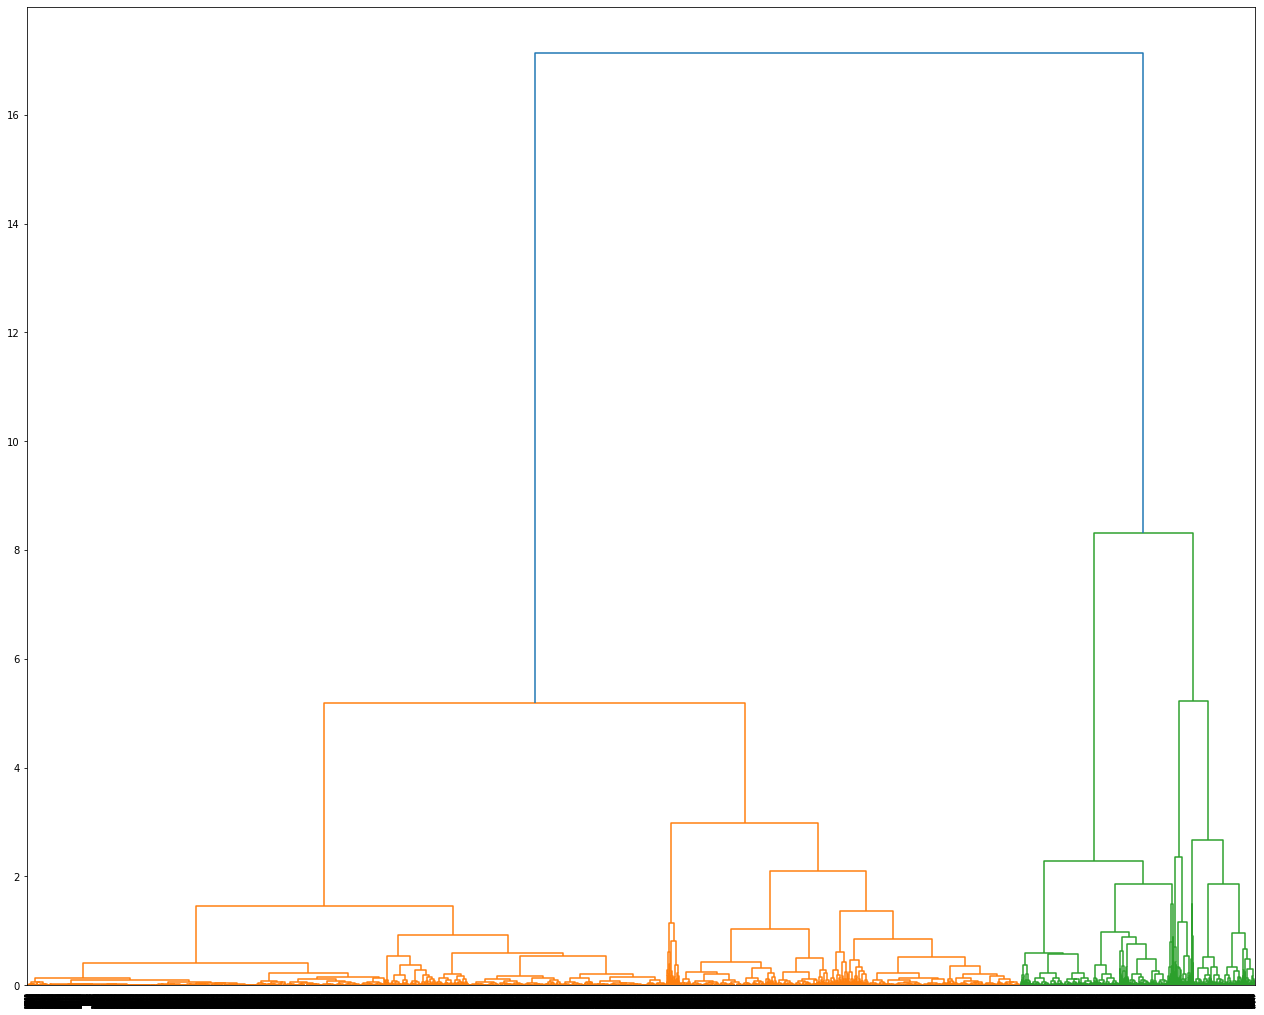

In [23]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(22,18))

# plot using 'dendrogram()'
dendrogram(linkage_matrix)

plt.show()

# Task 4. Cluster Analysis

a) Given the three hierarchical clusterings (i.e., from MIN, MAX and WARD,
compute and report their SSE (sum of squared errors). Additionally, show the
three clustering results using matplotlib.

In [24]:
SSE = []
cSingle = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single').fit(normalData)
singleLabels = cSingle.labels_
sPred = cSingle.fit_predict(normalData)
clf = NearestCentroid()
clf.fit(normalData, sPred)
centroids = clf.centroids_
clustLabels = singleLabels
#sse
sseSum = 0.0
cSum = 0.0
for i in range(2):
    val = (np.where(clustLabels == i))[0]
    for w in range(len(val)):
        xVal = normalData.iloc[val[w]][0]
        sseSum += np.square(np.linalg.norm(centroids[i,:] - xVal))
SSE.append(sseSum)

print("Min linkage clustering SSE: ", SSE)

Min linkage clustering SSE:  [2229.1892284371283]


C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\3710895189.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\3710895189.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


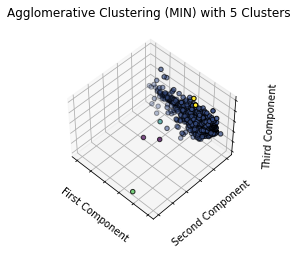

In [25]:
# matplotlib plot for Min
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = singleLabels

ax.scatter(normalData[0], normalData[1], normalData[2],c=labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
ax.set_zlabel('Third Component')
ax.set_title('Agglomerative Clustering (MIN) with 5 Clusters')
ax.dist = 12
fignum = 2

fig.show()

In [26]:
SSE = []
cComplete = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete').fit(normalData)
completeLabels = cComplete.labels_
sPred = cComplete.fit_predict(normalData)
clf = NearestCentroid()
clf.fit(normalData, sPred)
centroids = clf.centroids_
clustLabels = completeLabels
#sse
sseSum = 0.0
cSum = 0.0
for i in range(2):
    val = (np.where(clustLabels == i))[0]
    for w in range(len(val)):
        xVal = normalData.iloc[val[w]][0]
        sseSum += np.square(np.linalg.norm(centroids[i,:] - xVal))
SSE.append(sseSum)

print("Max linkage clustering SSE: ", SSE)

Max linkage clustering SSE:  [2127.715976670422]


C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\2831949032.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\2831949032.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


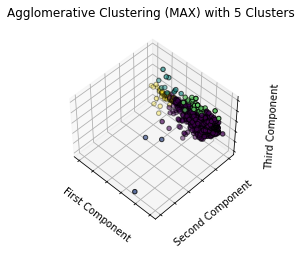

In [27]:
# matplotlib plot for Max
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = completeLabels

ax.scatter(normalData[0], normalData[1], normalData[2],c=labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
ax.set_zlabel('Third Component')
ax.set_title('Agglomerative Clustering (MAX) with 5 Clusters')
ax.dist = 12
fignum = 2

fig.show()

In [28]:
SSE = []
cWard = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(normalData)
wardLabels = cWard.labels_
sPred = cWard.fit_predict(normalData)
clf = NearestCentroid()
clf.fit(normalData, sPred)
centroids = clf.centroids_
clustLabels = wardLabels
#sse
sseSum = 0.0
cSum = 0.0
for i in range(2):
    val = (np.where(clustLabels == i))[0]
    for w in range(len(val)):
        xVal = normalData.iloc[val[w]][0]
        sseSum += np.square(np.linalg.norm(centroids[i,:] - xVal))
SSE.append(sseSum)

print("Ward linkage clustering SSE: ", SSE)

Ward linkage clustering SSE:  [624.540166663375]


C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\3344168560.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\3344168560.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


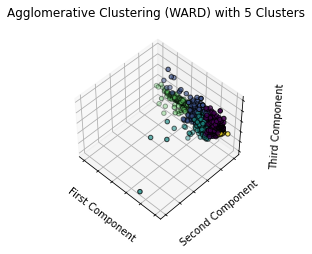

In [29]:
# matplotlib plot for Ward
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = wardLabels

ax.scatter(normalData[0], normalData[1], normalData[2],c=labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
ax.set_zlabel('Third Component')
ax.set_title('Agglomerative Clustering (WARD) with 5 Clusters')
ax.dist = 12
fignum = 2

fig.show()

b) Apply external measures, specifically GINI Index, entropy, and percentage of
defaults, on the default status to assess the quality of clusterings. Which measure
is a better tool? Which measure can reveal more interesting information under the
context of this application?

In [32]:
# First, let's find Gini index of Default status of each cluster
def GINI(data, labels, default, k):
    gini = [1] * k
    clustered = data.copy()
    clustered['LABEL'] = labels
    clustered['DEFAULT'] = default
    for i in range(k):
        cluster = clustered[clustered['LABEL'] == i]
        defaults = len(cluster[cluster['DEFAULT'] == 1])
        if(len(cluster) == 0):
            gini[i] = -1
        else:
            gini[i] -= ((float(defaults) / len(cluster))**2) + ((1 - float(defaults) / len(cluster))**2)
    return gini

In [41]:
# Gini index for each of the clusters: MIN
GINI(normalData, singleLabels, data['default payment next month'], 5)

[0.0, 0.346696104161352, 0.0, 0.0, 0.0]

In [42]:
# Gini index for each of the clusters: MAX
GINI(normalData, completeLabels, data['default payment next month'], 5)

[0.3463505057427154,
 0.0,
 0.49586776859504145,
 0.2975206611570249,
 0.41584483892176205]

In [43]:
# Gini index for each of the clusters: WARD
GINI(normalData, wardLabels, data['default payment next month'], 5)

[0.34510824635045245,
 0.3238656591650413,
 0.318949025363262,
 0.39900265118040656,
 0.35421381483103764]

In [65]:
# Secondly, we calculate entropy
from scipy.stats import entropy
from math import log, e
import timeit

def ENTROPY(labels, base=None):
  """ Computes entropy of label distribution. """

  n_labels = len(labels)

  if n_labels <= 1:
    return 0

  value,counts = np.unique(labels, return_counts=True)
  probs = counts / n_labels
  n_classes = np.count_nonzero(probs)

  if n_classes <= 1:
    return 0

  ent = 0.

  # Compute entropy
  base = e if base is None else base
  for i in probs:
    ent -= i * log(i, base)

  return ent

In [66]:
# Entropy for single/min linkage 
ENTROPY(singleLabels)

0.0026558964946346766

In [67]:
# Entropy for complete/max linkage
ENTROPY(completeLabels)

0.037521638680803715

In [68]:
# Entropy for ward linkage
ENTROPY(wardLabels)

1.1721481292552052

In [69]:
# Thirdly, we find the Percentage of defaults in each cluster
def POD(data, labels, default, k):
    pod = [0] * k
    clustered = data.copy()
    clustered['LABEL'] = labels
    clustered['DEFAULT'] = default
    for i in range(k):
        cluster = clustered[clustered['LABEL'] == i]
        defaults = len(cluster[cluster['DEFAULT'] == 1])
        if(len(cluster) == 0):
            pod[i] = -1
        else:
            pod[i] = (float(defaults) / len(cluster))
    return pod

In [70]:
# Percentage of defaults for single/min linkage
POD(normalData, singleLabels, data['default payment next month'], 5)

[0.0, 0.22313911811286155, 0.0, 0.0, 0.0]

In [71]:
# Percentage of defaults for complete/max linkage
POD(normalData, completeLabels, data['default payment next month'], 5)

[0.22282722513089004,
 0.0,
 0.45454545454545453,
 0.18181818181818182,
 0.2948717948717949]

In [72]:
# Percentage of defaults for ward linkage
POD(normalData, wardLabels, data['default payment next month'], 5)

[0.22170900692840648,
 0.20323886639676114,
 0.1991254624957955,
 0.2752808988764045,
 0.23001279181323953]

c) Upon the clustering selected based on the best SSE, perform data analysis of
clusters for comparison, e.g., in terms of the characteristics and distribution of
data points in those clusters
* clustering selected based on the best SSE -> Ward Linkage: wardLabels

In [81]:
# read csv data
_table = pd.read_csv('credit cards-2022-post.csv')
_table

# add Remaining_Balance colums
for i in range(1,7):
    _table[f'Remaining_Balance{i}']= _table[f'BILL_AMT{i}']- _table[f'PAY_AMT{i}']
    
#  Remove non-relevant colums
drop_column = [i for i in range(12)]
drop_column.append(24)
table = _table.drop(_table.columns[drop_column], axis=1) 
table['BILL_AMT1']

client_data = _table.to_dict()
_table

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,Remaining_Balance1,Remaining_Balance2,Remaining_Balance3,Remaining_Balance4,Remaining_Balance5,Remaining_Balance6
0,5771,180000,1,2,1,38,1,2,2,0,...,124,0,0,1,826,4412,4071,4947,5195,0
1,3999,20000,2,1,2,23,2,2,2,2,...,500,0,1000,1,6236,12559,11459,12457,13104,11744
2,397,100000,1,1,2,38,0,0,0,0,...,0,579,0,0,38308,41453,41491,43011,42432,28947
3,15467,220000,1,1,2,30,2,0,0,0,...,4000,4000,5000,0,79630,82604,85487,86889,87892,88815
4,16482,240000,2,4,1,59,0,0,0,0,...,10000,5000,20000,0,225561,225403,226564,231075,141440,112290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,20939,280000,1,2,2,39,-2,-2,-2,-2,...,0,0,0,0,-6326,7604,697,4071,-30,-30
23996,4919,260000,2,1,2,39,0,0,0,0,...,3040,20000,30007,0,77747,102898,111976,92935,42817,31214
23997,1437,80000,2,1,2,29,0,0,0,2,...,3000,3000,3000,1,78495,59878,82215,77422,75284,74270
23998,1764,500000,1,1,2,33,-1,-1,-1,-2,...,7963,196,7083,0,3314,-8494,6345,-3805,7762,-7279


In [84]:
def separate_client(feature, label, k=5):
    data_points = {}
    for key, value in feature.items():
        data_points[key] = [[] for i in range(k)]
        for index in range(len(value.values())):
            data_points[key][label[index]].append(value[index])
    return data_points

In [85]:
client_information = separate_client(client_data, wardLabels)

In [87]:
client_data.keys()

dict_keys(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month', 'Remaining_Balance1', 'Remaining_Balance2', 'Remaining_Balance3', 'Remaining_Balance4', 'Remaining_Balance5', 'Remaining_Balance6'])

In [88]:
len(client_information['AGE'])

5

In [89]:
len(client_data['ID'].values())

24000

In [90]:
from  collections import Counter
from collections import OrderedDict

def get_portion(data_list, overall_counts,fun=lambda x:x):

    # this function is used to get label (global)    
    label_counts = Counter(fun(sample) for sample in data_list)
    probabilities = {}
    
    for k, v in label_counts.items():
        probabilities[k] = float(v)/overall_counts[k]

    p_ascending = OrderedDict(sorted(probabilities.items(), key=lambda kv: kv[0]))
    return p_ascending

In [91]:

def calGini(data_list, fun=lambda x:x):
#     calculate gini index
    label_counts = Counter(fun(sample) for sample in data_list)
    probabilities = {k:float(v)/sum(label_counts.values()) for k, v in label_counts.items()}
    result = 0
    
    p_ascending = OrderedDict(sorted(probabilities.items(), key=lambda kv: kv[0]))
    for prob in p_ascending.values():
        result += prob*(1-prob)
    return result, p_ascending

In [92]:
def age_range(x):
#     convert age to spefic label
    if x<20:
        return 0
    elif x<30:
        return 1
    elif x<40:
        return 2
    elif x<50:
        return 3
    elif x<60:
        return 4
    else:
        return 5
    

In [93]:
# get mean balance over 6 Remaining Balance data
balance_mean = []
for index in range(len(client_data['Remaining_Balance1'])):
    temp_ = 0
    for i in range(1,7):
        temp_ += client_data[f'Remaining_Balance{i}'][index]
    balance_mean.append(temp_/6)
balance_mean

[3241.8333333333335,
 11259.833333333334,
 39273.666666666664,
 85219.5,
 193722.16666666666,
 12331.333333333334,
 -31.666666666666668,
 12526.5,
 11501.0,
 68433.33333333333,
 0.0,
 37507.333333333336,
 42000.833333333336,
 12194.5,
 13899.666666666666,
 0.0,
 195.0,
 -3.5,
 15510.0,
 -295.1666666666667,
 -286.5,
 -125.66666666666667,
 2877.3333333333335,
 15882.666666666666,
 17119.666666666668,
 1010.8333333333334,
 17285.0,
 4338.0,
 39654.666666666664,
 62436.833333333336,
 2628.0,
 39221.5,
 119.33333333333333,
 309.8333333333333,
 16467.166666666668,
 78067.33333333333,
 52465.166666666664,
 177.33333333333334,
 16011.5,
 124276.83333333333,
 1380.3333333333333,
 8949.666666666666,
 37683.333333333336,
 -210.66666666666666,
 15660.833333333334,
 33544.833333333336,
 62514.833333333336,
 44955.333333333336,
 5379.166666666667,
 38488.666666666664,
 94952.5,
 35432.333333333336,
 -36.166666666666664,
 0.0,
 8089.166666666667,
 254.66666666666666,
 123022.16666666667,
 8197.833333

In [94]:
len(balance_mean)

24000

In [95]:
def show_feature(feature):
    # Calculate Impurity (Gini Index) and percentage 
    dict_single = {}
    gini_index = feature[0][0]
    dict_single['Impurity (Gini Index)'] = "%.2f"%feature[0][0]
    
    for k,v in feature[0][1].items():
        dict_single[f'label{k}(local)'] =  "%.3f" % (v*100)+'%'
    for k,v in feature[1].items():
        dict_single[f'label{k}(global)'] =  "%.2f" % (v*100)+'%'
    return dict_single

In [97]:
# sex
from pandas import Series,DataFrame

output_dict = {}
SEX_feature = []
fun=lambda x:x
print('Data type {}'.format('SEX'))
for i in range(5):
    feature_temp = []
    overall_counts = Counter([fun(sample) for sample in client_data['SEX'].values()])
    feature_temp.append(calGini(client_information['SEX'][i]))
    feature_temp.append(get_portion(client_information['SEX'][i], overall_counts ))
    output_dict[f'cluster{i}']=show_feature(feature_temp)
    
df = DataFrame(output_dict)
df


Data type SEX


,cluster0,cluster1,cluster2,cluster3,cluster4
Impurity (Gini Index),0.48,0.49,0.47,0.49,0.48
label1(local),40.647%,43.320%,38.446%,43.539%,38.871%
label2(local),59.353%,56.680%,61.554%,56.461%,61.129%
label1(global),29.61%,5.63%,12.02%,1.63%,51.12%
label2(global),28.38%,4.83%,12.63%,1.39%,52.77%


In [98]:
# education
output_dict = {}
EDUCATION_feature = []
fun=lambda x:x
print('Data type {}'.format('EDUCATION'))
for i in range(5):
    feature_temp = []
    overall_counts = Counter([fun(sample) for sample in client_data['EDUCATION'].values()])
    feature_temp.append(calGini(client_information['EDUCATION'][i]))
    feature_temp.append(get_portion(client_information['EDUCATION'][i], overall_counts ))
    output_dict[f'cluster{i}']=show_feature(feature_temp)
df = DataFrame(output_dict)
df = df.fillna(0)
df

Data type EDUCATION


,cluster0,cluster1,cluster2,cluster3,cluster4
Impurity (Gini Index),0.62,0.62,0.61,0.61,0.63
label1(local),28.334%,37.976%,32.560%,48.315%,38.823%
label2(local),51.155%,46.802%,50.925%,38.202%,43.676%
label3(local),19.096%,12.551%,14.295%,11.236%,16.182%
label4(local),0.245%,0.567%,0.471%,0.281%,0.512%
label5(local),1.025%,1.862%,1.480%,1.685%,0.592%
label6(local),0.144%,0.243%,0.269%,0.281%,0.160%
label1(global),23.29%,5.56%,11.49%,2.04%,57.62%
label2(global),31.54%,5.14%,13.48%,1.21%,48.62%
label3(global),33.35%,3.91%,10.71%,1.01%,51.02%


In [99]:
# MARRIAGE
output_dict = {}
MARRIAGE_feature = []
fun=lambda x:x
print('Data type {}'.format('MARRIAGE'))
for i in range(5):
    feature_temp = []
    overall_counts = Counter([fun(sample) for sample in client_data['MARRIAGE'].values()])
    feature_temp.append(calGini(client_information['MARRIAGE'][i]))
    feature_temp.append(get_portion(client_information['MARRIAGE'][i], overall_counts ))
    output_dict[f'cluster{i}']=show_feature(feature_temp)
df = DataFrame(output_dict)
df = df.fillna(0)
df

Data type MARRIAGE


,cluster0,cluster1,cluster2,cluster3,cluster4
Impurity (Gini Index),0.51,0.51,0.51,0.50,0.51
label0(local),0.144%,0,0.034%,0,0.256%
label1(local),43.894%,49.312%,47.494%,50.562%,45.659%
label2(local),54.734%,50.040%,51.900%,49.438%,52.934%
label3(local),1.227%,0.648%,0.572%,0,1.151%
label0(global),23.26%,0,2.33%,0,74.42%
label1(global),27.76%,5.56%,12.89%,1.64%,52.14%
label2(global),29.74%,4.85%,12.10%,1.38%,51.93%
label3(global),33.46%,3.15%,6.69%,0,56.69%


In [100]:
def separate_points(temp, label, k=5):
    data_points = [[] for i in range(k)]
    for index in range(len(temp)):
        data_points[label[index]].append(temp[index])
    data_points = [np.array(datas) for datas in data_points]
    return data_points

In [101]:
my_data_points = separate_points(balance_mean, wardLabels)
my_data_points

[array([39273.66666667, 12331.33333333, 12526.5       , ...,
        60687.16666667, 46235.33333333, 57686.83333333]),
 array([193722.16666667,  50904.16666667, 171584.        , ...,
        153350.        , 158397.83333333, 184867.16666667]),
 array([ 85219.5       ,  78067.33333333, 124276.83333333, ...,
         76597.83333333,  74594.        , 141804.33333333]),
 array([289248.33333333, 416370.83333333, 253006.16666667, 301316.        ,
        264379.66666667, 354150.66666667, 331556.5       , 289932.83333333,
        292384.66666667, 275326.        , 300931.83333333, 296321.33333333,
        322032.5       , 331591.66666667, 286892.66666667, 475727.5       ,
        464446.33333333, 288154.83333333, 277389.66666667, 399704.66666667,
        282148.16666667, 238563.33333333, 298812.16666667, 252555.83333333,
        331538.        , 285116.5       , 242612.66666667, 241365.83333333,
        303731.5       , 259267.5       , 347496.66666667, 398082.66666667,
        345326.83333333

In [102]:
for i in range(5):
    print('The mean balance of cluster {} is {}'.format(i,np.mean(my_data_points[i])))

The mean balance of cluster 0 is 37337.76224499615
The mean balance of cluster 1 is 182500.06666666665
The mean balance of cluster 2 is 98408.85486041036
The mean balance of cluster 3 is 320719.26451310865
The mean balance of cluster 4 is 4892.7793945208405


In [103]:
# age
output_dict = {}
Age_feature = []
fun= age_range
print('Data type {}'.format('Age'))
for i in range(5):
    feature_temp = []
    overall_counts = Counter([fun(sample) for sample in client_data['AGE'].values()])
    feature_temp.append(calGini(client_information['AGE'][i], fun))
    feature_temp.append(get_portion(client_information['AGE'][i], overall_counts, fun ))
    output_dict[f'cluster{i}']=show_feature(feature_temp)
df = DataFrame(output_dict)
df = df.fillna(0)
df

Data type Age


,cluster0,cluster1,cluster2,cluster3,cluster4
Impurity (Gini Index),0.70,0.68,0.70,0.69,0.71
label1(local),35.826%,20.891%,28.591%,15.449%,32.099%
label2(local),34.714%,45.587%,41.002%,45.787%,36.888%
label3(local),20.626%,24.049%,21.897%,25.843%,22.194%
label4(local),7.809%,7.692%,7.366%,10.955%,7.659%
label5(local),1.025%,1.781%,1.144%,1.966%,1.159%
label1(global),32.40%,3.37%,11.10%,0.72%,52.42%
label2(global),26.83%,6.28%,13.60%,1.82%,51.47%
label3(global),27.24%,5.66%,12.41%,1.75%,52.93%
label4(global),29.21%,5.13%,11.83%,2.11%,51.73%


In [104]:
# Now let's see how age and education level affect means balance
def cal_mean_print(dic):
    for k, v in dic.items():
        if len(v)!=0:
            print('mean balance of label {} if {}'. format(k, sum(v)/len(v)))
        else:
            print('mean balance of label {} if {}'. format(k, 0))

In [105]:
len(client_data['EDUCATION'].values())

24000

In [106]:
age_dict ={i:[] for i in range(6)}
edu_dict ={i:[] for i in range(7)}
for age_temp, balance_temp, edu_temp in zip( client_data['AGE'].values(), balance_mean, client_data['EDUCATION'].values()):
    age_dict[age_range(age_temp)].append(balance_temp)
    edu_dict[edu_temp].append(balance_temp)
print('data type {}'.format('Age'))
cal_mean_print(age_dict)
print('data type {}'.format('Education'))
cal_mean_print(age_dict)

data type Age
mean balance of label 0 if 0
mean balance of label 1 if 34683.92308529154
mean balance of label 2 if 42560.17354603602
mean balance of label 3 if 40606.82319669527
mean balance of label 4 if 42147.95410367177
mean balance of label 5 if 49387.17682198326
data type Education
mean balance of label 0 if 0
mean balance of label 1 if 34683.92308529154
mean balance of label 2 if 42560.17354603602
mean balance of label 3 if 40606.82319669527
mean balance of label 4 if 42147.95410367177
mean balance of label 5 if 49387.17682198326


In [107]:
my_data_points_mean = separate_points(balance_mean, wardLabels)

age_values = [v for k, v in client_data['AGE'].items()]
edu_values = [v for k, v in client_data['EDUCATION'].items()]
my_data_points_age = separate_points(age_values, wardLabels)
my_data_points_edu = separate_points(edu_values, wardLabels)

In [108]:
def cal_mean(dic):
    new_dict = {}
    for k, v in dic.items():
        if len(v)!=0:
            new_dict[f'label{k}'] = sum(v)/len(v)
        else:
            new_dict[f'label{k}'] = 0
    return new_dict

In [109]:
cluster_dict_age = {}
cluster_dict_edu = {}
for cluster_index in range(5):
    age_dict ={i:[] for i in range(6)}
    edu_dict ={i:[] for i in range(7)}
    for age_temp, balance_temp, edu_temp in zip( my_data_points_age[cluster_index], my_data_points_mean[cluster_index], my_data_points_edu[cluster_index]):
        age_dict[age_range(age_temp)].append(balance_temp)
        edu_dict[edu_temp].append(balance_temp)
    cluster_dict_age[f'cluster{cluster_index}']=cal_mean(age_dict)
    cluster_dict_edu[f'cluster{cluster_index}']=cal_mean(edu_dict)
print('data type {}'.format('Age'))  
new_df = DataFrame(cluster_dict_age)
new_df

data type Age


,cluster0,cluster1,cluster2,cluster3,cluster4
label0,0.000000,0.000000,0.000000,0.000000,0.000000
label1,38250.613820,178916.199612,97397.286863,304379.839394,6239.567331
label2,36681.770132,182456.874186,99176.116626,315220.080777,3964.013654
label3,36626.578027,183049.277217,97794.118024,327332.398551,4502.601165
label4,37452.424522,190160.382456,98317.827245,343595.068376,5009.604558
label5,41087.246479,185141.409091,108546.191176,362786.500000,3852.695402


In [110]:
print('data type {}'.format('Education')) 
new_df = DataFrame(cluster_dict_edu)
new_df

data type Education


,cluster0,cluster1,cluster2,cluster3,cluster4
label0,0.000000,0.000000,0.000000,0.000000,1599.071429
label1,34926.290457,181075.269012,97369.079029,327013.688953,2948.035729
label2,38060.839682,185414.020185,98662.034126,313041.948529,6218.803893
label3,38705.905266,177867.602151,99911.747843,317860.983333,6056.446229
label4,47928.294118,177704.000000,102044.833333,277662.500000,1929.221354
label5,39913.309859,165624.326087,97086.943182,353188.861111,5676.858108
label6,37155.416667,223737.222222,97373.916667,244763.666667,4844.958333


d) In Task 1(c), the data points are normalized. Is it really better than clustering
without preprocessing with normalization? Please use data without normalization
to find the best clustering.

In [125]:
# Now let's run without normalizing
for i in range(1, 7):
    categories.append('BILL_AMT'+str(i))
    categories.append('PAY_AMT'+str(i))
    categories.append('REM_AMT'+str(i))
dataset2 = pd.DataFrame(data, columns=categories)
dataset2.head()

,BILL_AMT1,PAY_AMT1,REM_AMT1,BILL_AMT2,PAY_AMT2,REM_AMT2,BILL_AMT3,PAY_AMT3,REM_AMT3,BILL_AMT4,...,REM_AMT3,BILL_AMT4,PAY_AMT4,REM_AMT4,BILL_AMT5,PAY_AMT5,REM_AMT5,BILL_AMT6,PAY_AMT6,REM_AMT6
0,2826,2000,826,4612,200,4412,4571,500,4071,5071,...,4071,5071,124,4947,5195,0,5195,0,0,0
1,9736,3500,6236,12759,200,12559,12459,1000,11459,12957,...,11459,12957,500,12457,13104,0,13104,12744,1000,11744
2,40810,2502,38308,42653,1200,41453,42351,860,41491,43011,...,41491,43011,0,43011,43011,579,42432,28947,0,28947
3,84630,5000,79630,87604,5000,82604,89687,4200,85487,90889,...,85487,90889,4000,86889,91892,4000,87892,93815,5000,88815
4,233918,8357,225561,235404,10001,225403,236564,10000,226564,241075,...,226564,241075,10000,231075,146440,5000,141440,132290,20000,112290


In [126]:
# we still do data preprocessing: Peform PCA to reduce dimensionality to 3
pca = PCA(n_components=3)
not_normalData = pd.DataFrame(pca.fit_transform(dataset2))
not_normalData.head()

,0,1,2
0,-234900.072834,979.704734,-1030.543185
1,-186011.468525,11715.173306,-7312.021001
2,-17343.912388,8389.925093,-2407.235079
3,265624.057583,60063.369200,-24593.986187
4,957129.792929,-94589.741588,94351.151487


In [127]:
SSE = []
cSingle = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single').fit(not_normalData)
singleLabels2 = cSingle.labels_
sPred = cSingle.fit_predict(not_normalData)
clf = NearestCentroid()
clf.fit(not_normalData, sPred)
centroids = clf.centroids_
clustLabels = singleLabels2
#sse
sseSum = 0.0
cSum = 0.0
for i in range(2):
    val = (np.where(clustLabels == i))[0]
    for w in range(len(val)):
        xVal = not_normalData.iloc[val[w]][0]
        sseSum += np.square(np.linalg.norm(centroids[i,:] - xVal))
SSE.append(sseSum)

print("Min linkage clustering SSE: ", SSE)

Min linkage clustering SSE:  [9845831910362090.0]


C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\4197485243.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\4197485243.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


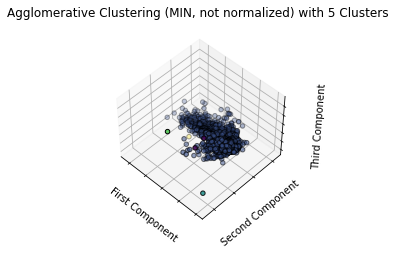

In [128]:
# matplotlib plot for Min
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels2 = singleLabels2

ax.scatter(not_normalData[0], not_normalData[1], not_normalData[2],c=labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
ax.set_zlabel('Third Component')
ax.set_title('Agglomerative Clustering (MIN, not normalized) with 5 Clusters')
ax.dist = 12
fignum = 2

fig.show()

In [129]:
SSE = []
cComplete = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='complete').fit(not_normalData)
completeLabels2 = cComplete.labels_
sPred = cComplete.fit_predict(not_normalData)
clf = NearestCentroid()
clf.fit(not_normalData, sPred)
centroids = clf.centroids_
clustLabels = completeLabels2
#sse
sseSum = 0.0
cSum = 0.0
for i in range(2):
    val = (np.where(clustLabels == i))[0]
    for w in range(len(val)):
        xVal = not_normalData.iloc[val[w]][0]
        sseSum += np.square(np.linalg.norm(centroids[i,:] - xVal))
SSE.append(sseSum)

print("Max linkage clustering SSE: ", SSE)

Max linkage clustering SSE:  [3529148510186874.0]


C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\942030080.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\942030080.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


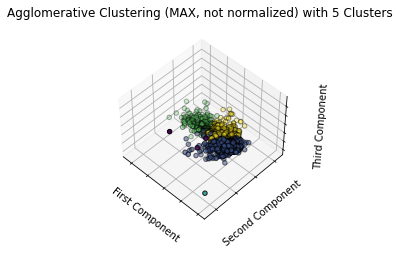

In [130]:
# matplotlib plot for Max
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = completeLabels2

ax.scatter(not_normalData[0], not_normalData[1], not_normalData[2],c=labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
ax.set_zlabel('Third Component')
ax.set_title('Agglomerative Clustering (MAX, not normalized) with 5 Clusters')
ax.dist = 12
fignum = 2

fig.show()

In [131]:
SSE = []
cWard = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(not_normalData)
wardLabels2 = cWard.labels_
sPred = cWard.fit_predict(not_normalData)
clf = NearestCentroid()
clf.fit(not_normalData, sPred)
centroids = clf.centroids_
clustLabels = wardLabels2
#sse
sseSum = 0.0
cSum = 0.0
for i in range(2):
    val = (np.where(clustLabels == i))[0]
    for w in range(len(val)):
        xVal = not_normalData.iloc[val[w]][0]
        sseSum += np.square(np.linalg.norm(centroids[i,:] - xVal))
SSE.append(sseSum)

print("Ward linkage clustering SSE: ", SSE)

Ward linkage clustering SSE:  [3614092780095645.0]


C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\156929285.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
C:\Users\ybxYB\AppData\Local\Temp\ipykernel_5424\156929285.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


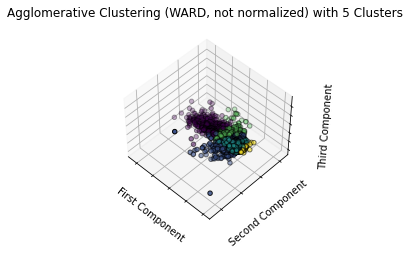

In [132]:
# matplotlib plot for Ward
fig = plt.figure(2, figsize=(4, 3))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
labels = wardLabels2

ax.scatter(not_normalData[0], not_normalData[1], not_normalData[2],c=labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('First Component')
ax.set_ylabel('Second Component')
ax.set_zlabel('Third Component')
ax.set_title('Agglomerative Clustering (WARD, not normalized) with 5 Clusters')
ax.dist = 12
fignum = 2

fig.show()